#### I couldn't do much due to my schedule with the comprehensive exam preparation. I have tried to go over most of the topics covered on the geopandas documentation. I wanted to download a shapefile with tracts for Shelby County then make various calculations such as counting the libraries per tract but I got out of time. 

## IMPORTING


In [66]:
import geopandas as gpd
import fiona
import folium
import geopy

path = r'/Users/berkaytok/DataspellProjects/AdvGIS/data/Shelby.gdb.zip'

df = gpd.read_file(path, driver='FileGDB', layer=0)
fiona.listlayers(path)

['Community_Garden_shelby',
 'School_shelby',
 'Rail_shelby',
 'Parks_shelby',
 'Library_shelby',
 'Law_Enforcement_shelby',
 'Hospital_shelby',
 'Health_Centers_shelby',
 'Grocer_shelby',
 'Fire_shelby',
 'Farmer_Market_shelby',
 'County_shelby',
 'roads_shelby']

In [67]:
county = gpd.read_file(path, driver='FileGDB', layer='County_shelby')
schools = gpd.read_file(path, driver='FileGDB', layer='School_shelby')
libraries = gpd.read_file(path, driver='FileGDB', layer='Library_shelby')
parks = gpd.read_file(path, driver='FileGDB', layer='Parks_shelby')
fire = gpd.read_file(path, driver='FileGDB', layer='Fire_shelby')
law = gpd.read_file(path, driver='FileGDB', layer='Law_Enforcement_shelby')
libraries = gpd.read_file(path, driver='FileGDB', layer='Library_shelby')

#### SUBSETTING ROWS

In [68]:
parks.head(15)
parks[parks["NAME"] == "May Soccer Complex"]

PERMANENT_IDENTIFIER                NAME  PARKING_AREA  \
54  CPGIS47157031120131243157  May Soccer Complex     112207.07   

   PARKING_SURFMAT  Shape_Length    Shape_Area  \
54           Paved   7702.782893  2.795173e+06   

                                             geometry  
54  MULTIPOLYGON (((816224.514 291881.746, 816251....

In [69]:
# distance(): returns Series with minimum distance from each entry to other
# check distances of law to parks
law.distance(parks).head()

/Users/berkaytok/miniconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0    18174.534301
1    85771.950934
2    40163.747162
3    39424.673283
4    52866.966254
dtype: float64

<AxesSubplot:>

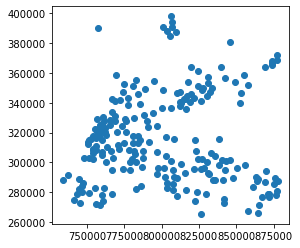

In [70]:
# Returns a GeoSeries of points for each geometric centroid
parks.centroid.plot()

In [71]:
# Returns a GeoSeries of (cheaply computed) points that are guaranteed to be within each geometry
schools.representative_point()

0      POINT (771013.978 280559.208)
1      POINT (757102.083 307819.399)
2      POINT (767691.110 320032.068)
3      POINT (779074.575 295587.880)
4      POINT (770590.992 295967.781)
                   ...              
386    POINT (876914.000 287984.793)
387    POINT (782192.227 371280.245)
388    POINT (827303.809 263306.056)
389    POINT (876424.270 355192.101)
390    POINT (805455.708 388577.776)
Length: 391, dtype: geometry

In [73]:
# check coordinate system to see if they are the same for a given layer
schools.crs == county.crs

True

In [74]:
# reproject to WGS84
schoolswgs = schools.to_crs(3857)

In [76]:
# almost equals
schoolswgs.geom_almost_equals(schools)

/Users/berkaytok/miniconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/base.py:1027: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:2274

  return _binary_op(


0      False
1      False
2      False
3      False
4      False
       ...  
386    False
387    False
388    False
389    False
390    False
Length: 391, dtype: bool

## INTERACTIVE MAPPING

In [77]:
county.explore()

## MAP OF SHELBY COUNTY PARKS COLORED BY PARKING AREA PER AREA TOTAL

In [82]:
# Shelby County Parks by parking space per area and libraries in Shelby County, TN
m = parks.explore(
     column=parks["PARKING_AREA"] / parks["Shape_Area"],  # make choropleth based on "BoroName" column
     scheme="quantiles",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     legend_kwds=dict(colorbar=False), # do not use colorbar
     name="parks" # name of the layer in the map
)
libraries.explore(
     m=m, # pass the map object
     color="red", # use red color on all points
     marker_kwds=dict(radius=10, fill=True), # make marker radius 10px with fill
     tooltip="Library_Na", # show "name" column in the tooltip
     tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
     name="libraries" # name of the layer in the map
)
folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m    

/Users/berkaytok/miniconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/berkaytok/miniconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 8
  Warn("Warning: setting k to %d" % k_q, UserWarning)


## GEOMETRIC MANIPULATIONS
#### OVERLAY/INTERSECTION

<AxesSubplot:>

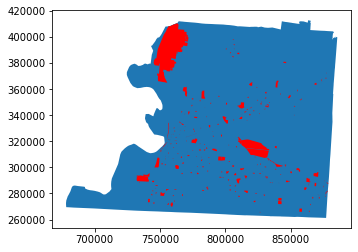

In [83]:
ax = parks.overlay(county, how='intersection').plot()
parks.plot(ax=ax, color='red', zorder=2)
county.plot(ax=ax, zorder=1)

#### DISSOLVE

<AxesSubplot:>

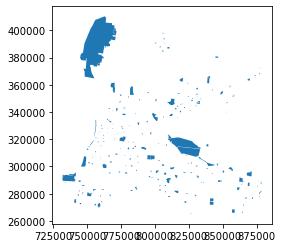

In [84]:
# dissolving the parks by the pavement type
parks.dissolve(by='PARKING_SURFMAT').plot()

## SPATIAL JOINS

In [85]:
# law enforcement inside Shelby County parks;
parklaw = law.sjoin(parks, how="inner", predicate='intersects')
parkgrp = parklaw.groupby(['NAME']).count()
parkgrp

PERMANENT_IDENTIFIER_left  SOURCE_FEATUREID  \
NAME                                                             
Firestone Park                             3                 3   
Hickory Hill Park                          1                 1   
Shelby Farms                               5                 5   

                   SOURCE_DATASETID  SOURCE_DATADESC  FTYPE  FCODE  \
NAME                                                                 
Firestone Park                    3                0      3      3   
Hickory Hill Park                 1                0      1      1   
Shelby Farms                      5                5      5      5   

                   FACILITY_NAME  PUB_PRI  ADMIN_TYPE  ADDRESS_BUILDING_NAME  \
NAME                                                                           
Firestone Park                 3        2           3                      0   
Hickory Hill Park              1        0           1                      0   
Shelby Farms                   5        5           5                      0   

                   ...  FACILITY_CITY  FACILITY_STATE  FACILITY_ZIP  geometry  \
NAME               ...                                                          
Firestone Park     ...              3               3             3         3   
Hickory Hill Park  ...              1               1             1         1   
Shelby Farms       ...              5               5             5         5   

                   index_right  PERMANENT_IDENTIFIER_right  PARKING_AREA  \
NAME                                                                       
Firestone Park               3                           3             3   
Hickory Hill Park            1                           1             1   
Shelby Farms                 5                           5             5   

                   PARKING_SURFMAT  Shape_Length  Shape_Area  
NAME                                                          
Firestone Park                   3             3           3  
Hickory Hill Park                1             1           1  
Shelby Farms                     5             5           5  

[3 rows x 24 columns]

## GEOCODING

In [86]:
# using the geocoding tool
shelby = parks.NAME.head()
geocoded = gpd.tools.geocode(shelby)
shelby


0         University Park
1            Jameson Park
2       Rodney Baber Park
3     Carver Heights Park
4    George Alberson Park
Name: NAME, dtype: object

In [87]:
# results are incorrect due to insufficient location names but geocoder works
geocoded

geometry                                          address
0  POINT (-87.68338 41.44003)  University Park, 60484, Illinois, United States
1  POINT (31.00900 -29.82735)                       Jameson Park, South Africa
2  POINT (-89.98370 35.19620)          Rodney Baber Park, 38127, United States
3  POINT (-76.43506 38.25590)     Carver Heights Community Park, United States
4  POINT (-61.34773 15.30588)                    Saint George Parish, Dominica

In [89]:
# using clear city names returns better results for geocoding
cities = ["San Antonio, TX", "New York, NY", "Los Angeles, CA", "Seattle, WA", "Miami, FL"]
gpd.tools.geocode(cities)

geometry                                        address
0   POINT (-96.73804 28.30528)             San Antonio Bay, TX, United States
1   POINT (-73.35669 40.74124)                    ny, New York, United States
2  POINT (-118.20968 34.31551)  Los Angeles County, California, United States
3  POINT (-122.33006 47.60383)             Seattle, Washington, United States
4   POINT (-80.49895 25.63642)      Miami-Dade County, Florida, United States